In [1]:
# Run this notebook to sanity check that all environments can run, render, and load offline data (when available)

%load_ext autoreload
%autoreload 2

from rlbase.common.envs.env_helper import make_env, get_dataset
from rlbase.common.dataset import Dataset
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import tabulate
data = [["EnvName", "Observation Space", "Action Space", "Example Obs", "Example Ac", "Offline Data Size", "Offline Obs", "Video"]]

def show_video(frames):
    stacked = np.stack(frames)
    while stacked.shape[2] > 160:
        stacked = stacked[:, ::2, ::2, :]
            
    from PIL import Image
    imgs = [Image.fromarray(img) for img in stacked]
    # duration is the number of milliseconds between frames; this is 40 frames per second
    gif_path = '/tmp/autoplay.gif'
    imgs[0].save(gif_path, save_all=True, append_images=imgs[1:], duration=50, loop=0)

    import base64
    from IPython.display import HTML
    b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
    return '<img height="200px" width="200px" src="data:image/gif;base64,{b64}" />'.format(b64=b64)
    # display(HTML(f'<img height="200px" src="data:image/gif;base64,{b64}" />'))

def render_video(env_name, offline_data=False):
    global data
    
    env = make_env(env_name)
    observation, done = env.reset(), False

    action = env.action_space.sample()
    if hasattr(action, "shape"):
        action = action[0:2]
    if hasattr(observation, "shape"):
        ob_shape = observation.shape
        ob = observation.flatten()[0:2]
    else:
        ob_shape = str({ob_part: observation[ob_part].shape for ob_part in observation}).replace(", '", ",<br>'")
        ob = str({ob_part: observation[ob_part].flatten()[0:2] for ob_part in observation}).replace(", '", ",<br>'")
    data_toadd = [env_name, ob_shape, env.action_space, ob, action]
    if offline_data:
        dataset = get_dataset(env, env_name)
        if type(dataset) == Dataset:
            data_toadd.append(dataset['observations'].shape)
        else:
            data_toadd.append(str(len(dataset.data)) + " " + str(dataset.sample(1)['observations'].shape))
        observation = dataset.sample(1)['observations']
        if hasattr(observation, "shape"):
            ob = observation.flatten()[0:2]
        else:
            ob = str({ob_part: observation[ob_part].flatten()[0:2] for ob_part in observation}).replace(", '", ",<br>'")
        data_toadd.append(ob)
    else:
        data_toadd.append("N/A")
        data_toadd.append("N/A")


    frames = []
    t = 0
    for i in range(1):
        while not done:
            t += 1
            action = env.action_space.sample()
            observation, r, done, info = env.step(action)
            if t == 10:
                break

            frames.append(env.env.render(mode="rgb_array"))
            if t % 100 == 0:
                print(t)
    env.close()
    img_str = show_video(frames)
    data_toadd.append(img_str)
    data += [data_toadd]

In [2]:
# DMC
render_video('cheetah_run')
render_video('walker_run')
render_video('quadruped_run')
render_video('humanoid_run')
render_video('cheetah_run_pixel')
render_video('humanoid_run_pixel')

# D4RL
render_video('kitchen-complete-v0')
render_video('maze2d-large-v1', offline_data=True)
render_video('antmaze-large-diverse-v2', offline_data=True)
render_video('gc-antmaze-large-diverse-v2-discrete', offline_data=True)

# ExORL
render_video('exorl_cheetah_run', offline_data=True)
render_video('exorl_walker_run', offline_data=True)

# Run these last because loading d4rl mujoco causes a bug with DMC mujoco.
render_video('HalfCheetah-v2')
render_video('Hopper-v2')
render_video('Walker2d-v2')

Normalizing Action Space from [-1.0, 1.0] to [-1, 1]
Normalizing Action Space from [-1.0, 1.0] to [-1, 1]
Normalizing Action Space from [-1.0, 1.0] to [-1, 1]
Normalizing Action Space from [-1.0, 1.0] to [-1, 1]
Normalizing Action Space from [-1.0, 1.0] to [-1, 1]
Normalizing Action Space from [-1.0, 1.0] to [-1, 1]


pybullet build time: May 20 2022 19:45:31


Reading configurations for Franka
Initializing Franka sim
Found 8 GPUs for rendering. Using device 0.
Target Goal:  (32.5323034292775, 24.96043658186029)


load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.79it/s]


Normalizing maze2d-large-v1
Target Goal:  (32.86170479042866, 25.04788861481925)
Target Goal:  (32.927879308725785, 25.0806803792138)


load datafile: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


NameError: name 'env_nam' is not defined

In [ ]:
# render_video('exorl_cheetah_run', offline_data=True)
# render_video('exorl_walker_run', offline_data=True)
render_video('ALE/Breakout')




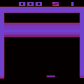

In [14]:
from IPython.display import HTML
table = tabulate.tabulate(data, tablefmt='html')
html = HTML(table)
html.data = html.data.replace('&lt;', '<').replace('&gt;', '>').replace('&quot;', '"')
display(html)
